In [1]:
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertTokenizer,
    BertModel,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed, BertConfig, BertTokenizer, BertForSequenceClassification,
)
import torch
import numpy as np

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-07-31 23:17:38,972] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [63]:
device = torch.device('cuda')
# model_path = 'path_to_vanilla_bert/../bert-base-uncased/'
model_path = 'path_to_finetuned_bert/../prompt1_result/'
config = AutoConfig.from_pretrained(model_path, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)
# tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_path,
#     from_tf=False,
#     config=config,
# )


model.to(device)

Some weights of the model checkpoint at /home/lichunhao/novel_need/prompt1_result/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [65]:
import torch
import pandas as pd

In [66]:
df_train = pd.read_csv('../data/bert/novel_train_generate_v2.csv')
df_valid = pd.read_csv('../data/bert/novel_valid_generate_v2.csv')

In [67]:
pos_sentences = []
neg_sentences = []
pos_sentences2 = []
neg_sentences2 = []
for _,row in df_valid.iterrows():
    if row['label']==0:
        neg_sentences.append(row['sentence1'])
    else:
        pos_sentences.append(row['sentence1'])
        
        
for _,row in df_train.iterrows():
    if not isinstance(row['sentence1'], str):
        continue
    if row['label']==0:
        neg_sentences2.append(row['sentence1'])
    else:
        pos_sentences2.append(row['sentence1'])

In [68]:
from tqdm import tqdm
pos_embeddings=[]
# pos_embeddings2=[]
neg_embeddings=[]

for sent in tqdm(pos_sentences+pos_sentences2):
    input_ids = torch.tensor(tokenizer.encode(sent, padding='max_length', max_length=128, truncation=True)).unsqueeze(0)
    outputs = model(input_ids.to(device))
    pos_embeddings.append(outputs[0].detach().cpu().numpy())
#     pos_embeddings2.append(outputs.last_hidden_state[0].detach().cpu().numpy())

    
for sent in tqdm(neg_sentences+neg_sentences2):
    input_ids = torch.tensor(tokenizer.encode(sent, padding='max_length', max_length=128, truncation=True)).unsqueeze(0)
    outputs = model(input_ids.to(device))
    neg_embeddings.append(outputs[0].detach().cpu().numpy())
    

100%|██████████| 16567/16567 [02:49<00:00, 97.68it/s] 


In [69]:
# pos_embeddings = np.array(pos_embeddings).reshape(len(pos_embeddings),2)
# neg_embeddings = np.array(neg_embeddings).reshape(len(neg_embeddings),2)

In [70]:
pos_embeddings = [emb[0] for emb in pos_embeddings]
neg_embeddings = [emb[0] for emb in neg_embeddings]

In [71]:
import random
neg_embeddings_random = random.choices(neg_embeddings, k=1000)
all_embeddings = np.concatenate([emb.reshape(emb.shape[0], -1) for emb in pos_embeddings+neg_embeddings_random])
all_embeddings.shape

(140544, 768)

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(all_embeddings)

PCA(n_components=2)

In [73]:
import random
all_embeddings= []
for emb in pos_embeddings:
    all_embeddings.append((emb, 1))
for emb in neg_embeddings_random:
    all_embeddings.append((emb, 0))
       
random.shuffle(all_embeddings)

No handles with labels found to put in legend.


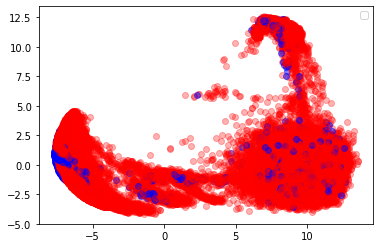

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# for pos_emb in pos_embeddings:
#     componenets = pca.transform(pos_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    
# for neg_emb in neg_embeddings_random:
#     componenets = pca.transform(neg_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.1)
    
for emb,label in all_embeddings:
    componenets = pca.transform(emb)
    if label ==1 :
        plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    else:
        plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.3)
plt.legend()
plt.show()

## prompt_v1_result

# tsne = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3)

# pos_embedded = tsne.fit_transform(pos_embeddings[0][0])
# neg_embedded = tsne.fit_transform(neg_embeddings)

No handles with labels found to put in legend.


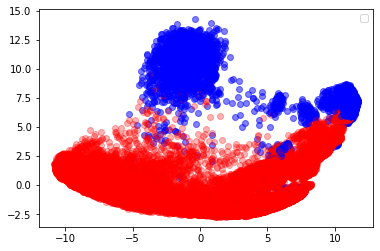

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# for pos_emb in pos_embeddings:
#     componenets = pca.transform(pos_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='blue')
    
# for neg_emb in neg_embeddings_random:
#     componenets = pca.transform(neg_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='red')
# plt.show()
## prompt_v1 result (fine-tuned)

for emb,label in all_embeddings:
    componenets = pca.transform(emb)
    if label ==1 :
        plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    else:
        plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.3)
plt.legend()
plt.show()

No handles with labels found to put in legend.


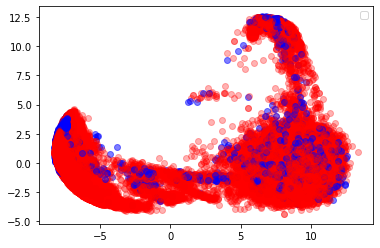

In [62]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# for pos_emb in pos_embeddings:
#     componenets = pca.transform(pos_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    
# for neg_emb in neg_embeddings_random:
#     componenets = pca.transform(neg_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.1)
    
for emb,label in all_embeddings:
    componenets = pca.transform(emb)
    if label ==1 :
        plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    else:
        plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.3)
plt.legend()
plt.show()

## generate_v1_result

# tsne = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3)

# pos_embedded = tsne.fit_transform(pos_embeddings[0][0])
# neg_embedded = tsne.fit_transform(neg_embeddings)

No handles with labels found to put in legend.


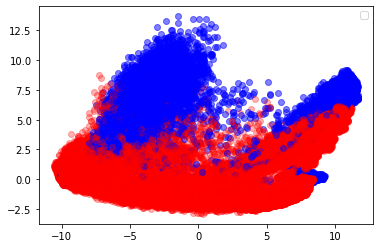

In [74]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# for pos_emb in pos_embeddings:
#     componenets = pca.transform(pos_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='blue')
    
# for neg_emb in neg_embeddings_random:
#     componenets = pca.transform(neg_emb)
#     plt.scatter(componenets[:,0], componenets[:,1], c='red')
# plt.show()
## generate_v1 result (fine-tuned)

for emb,label in all_embeddings:
    componenets = pca.transform(emb)
    if label ==1 :
        plt.scatter(componenets[:,0], componenets[:,1], c='blue', alpha=0.5)
    else:
        plt.scatter(componenets[:,0], componenets[:,1], c='red', alpha=0.3)
plt.legend()
plt.show()

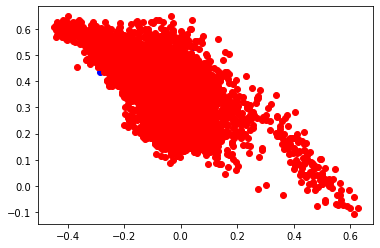

In [21]:
## generate_v1 vanilla model
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

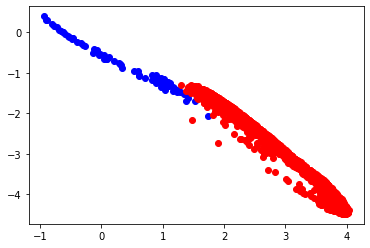

In [12]:
## generate_v1 finetuned model
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

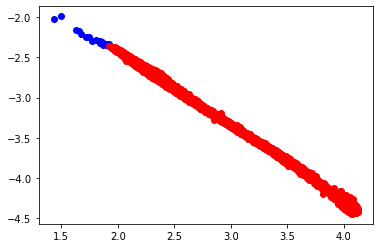

In [21]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')

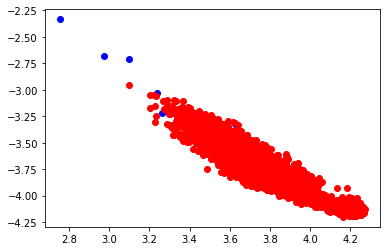

In [74]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.scatter(pos_embedded[:,0], pos_embedded[:, 1], c='blue')
# plt.scatter(neg_embedded[:,0], neg_embedded[:, 1], c='red')
plt.scatter(pos_embeddings[:,0], pos_embeddings[:, 1], c='blue')
plt.scatter(neg_embeddings[:,0], neg_embeddings[:, 1], c='red')